In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm
import logging
import os
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
#arima import
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.arima.model import ARIMA

In [90]:
df=pd.read_csv(r"C:\Users\Shaaf\Desktop\Data Science\Practice Projects\Agriculture Price Prediction\Data\preprocessed_data.csv")

In [91]:
df

,Date,Price
0,2016-01-31,7.643407
1,2016-02-29,7.616748
2,2016-03-31,7.619274
3,2016-04-30,7.579727
4,2016-05-31,7.845552
...,...,...
105,2024-10-31,7.808368
106,2024-11-30,7.313220
107,2024-12-31,7.734850
108,2025-01-31,7.624433


In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    110 non-null    object 
 1   Price   110 non-null    float64
dtypes: float64(1), object(1)
memory usage: 1.8+ KB


In [93]:
df.isnull().sum()

Date     0
Price    0
dtype: int64

In [94]:
df.set_index('Date',inplace=True)

In [95]:
#auto arima to find the best parameters 52week seasonality
stepwise_fit=pm.auto_arima(df['Price'],start_p=0,start_q=0,
                           max_p=6,max_q=6,m=12,
                            start_P=0,start_Q=0,seasonal=True,
                            d=1,D=1,trace=True,
                            error_action='ignore',
                            suppress_warnings=True,
                            stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=58.223, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=49.537, Time=0.11 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.26 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=59.053, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=45.467, Time=0.14 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=0.76 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.29 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=44.403, Time=0.12 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=48.560, Time=0.04 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=0.47 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.23 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=45.104, Time=0.16 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=45.866, Time=0.36 sec
 ARIMA(0,1,0)(2,1,0)[12] intercept   : AIC=46.383, Time=0.40 sec

Best model:  ARIMA(0,1,0)(2,1,0)[12]          
Total fit time

In [96]:
sarimax_model=SARIMAX(df['Price'],order=stepwise_fit.order,
                      seasonal_order=stepwise_fit.seasonal_order)
sarimax_model=sarimax_model.fit()

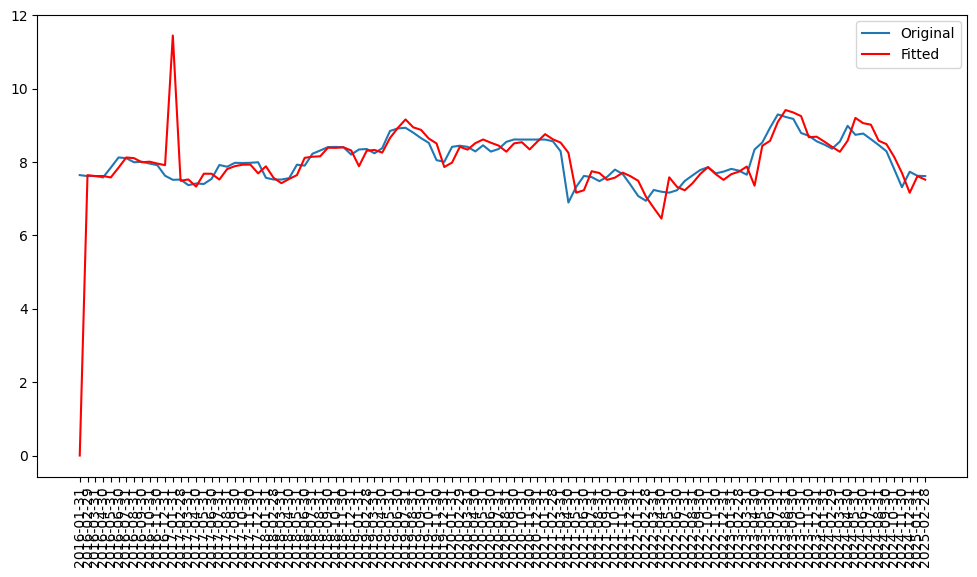

In [97]:
plt.figure(figsize=(12,6))
plt.plot(df['Price'],label='Original')
plt.plot(sarimax_model.fittedvalues,label='Fitted',color='red')
plt.legend()
plt.xticks(rotation=90)
plt.show()

In [98]:
sarimax_model.resid

Date
2016-01-31    7.643407
2016-02-29   -0.026659
2016-03-31    0.002526
2016-04-30   -0.039547
2016-05-31    0.265825
                ...   
2024-10-31   -0.330860
2024-11-30   -0.391363
2024-12-31    0.573459
2025-01-31    0.009097
2025-02-28    0.097985
Length: 110, dtype: float64

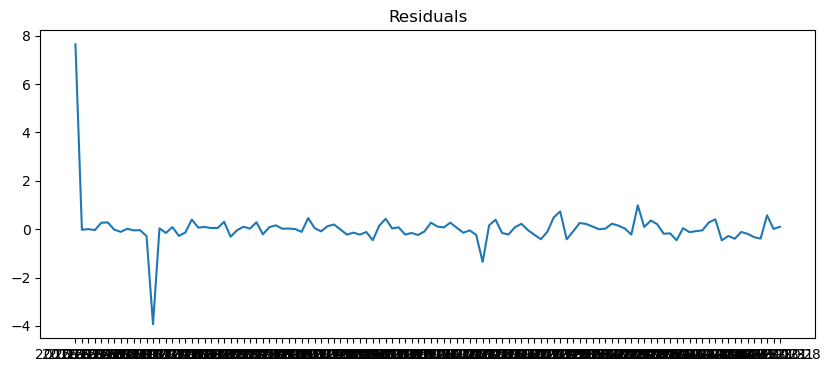

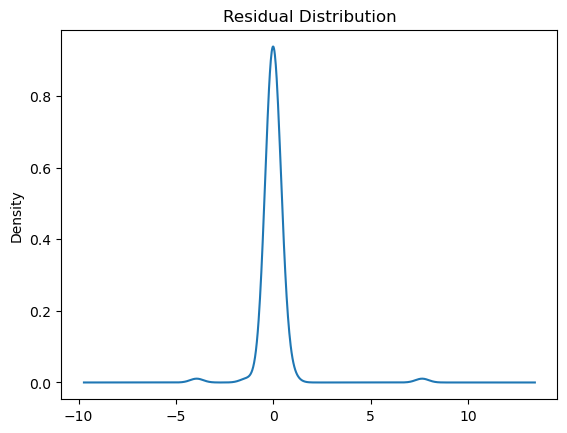

0.03288847570574015 0.8689468627036719


In [99]:
residuals = sarimax_model.resid
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.title("Residuals")
plt.show()

# Histogram
residuals.plot(kind='kde')
plt.title("Residual Distribution")
plt.show()

# Mean should be ~0
print(residuals.mean(), residuals.std())


In [100]:
df

,Price
Date,
2016-01-31,7.643407
2016-02-29,7.616748
2016-03-31,7.619274
2016-04-30,7.579727
2016-05-31,7.845552
...,...
2024-10-31,7.808368
2024-11-30,7.313220
2024-12-31,7.734850


In [101]:
df['Predictions']=sarimax_model.fittedvalues

In [102]:
df

,Price,Predictions
Date,,
2016-01-31,7.643407,0.000000
2016-02-29,7.616748,7.643407
2016-03-31,7.619274,7.616748
2016-04-30,7.579727,7.619274
2016-05-31,7.845552,7.579727
...,...,...
2024-10-31,7.808368,8.139228
2024-11-30,7.313220,7.704584
2024-12-31,7.734850,7.161391


In [103]:
#dropping first row as it contains NaN value
df=df.drop(df.index[0])

In [104]:
df

,Price,Predictions
Date,,
2016-02-29,7.616748,7.643407
2016-03-31,7.619274,7.616748
2016-04-30,7.579727,7.619274
2016-05-31,7.845552,7.579727
2016-06-30,8.124091,7.845552
...,...,...
2024-10-31,7.808368,8.139228
2024-11-30,7.313220,7.704584
2024-12-31,7.734850,7.161391


In [105]:
r2_score(df['Price'],df['Predictions'])

0.23548213531657924

In [106]:
mae = mean_absolute_error(df['Price'], df['Predictions'])
rmse = np.sqrt(mean_squared_error(df['Price'], df['Predictions']))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

MAE: 0.23
RMSE: 0.47


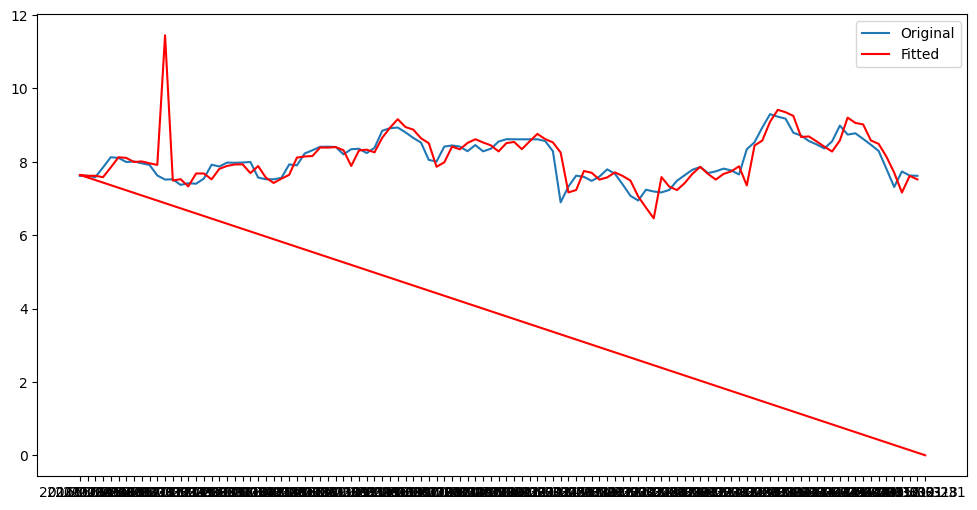

In [107]:
plt.figure(figsize=(12,6))
plt.plot(df['Price'],label='Original')
plt.plot(sarimax_model.fittedvalues,label='Fitted',color='red')
plt.legend()
plt.show()

In [108]:
arima_model=ARIMA(df['Price'],order=stepwise_fit.order)
arima_model=arima_model.fit()

In [109]:
stepwise_fit.order

(0, 1, 0)

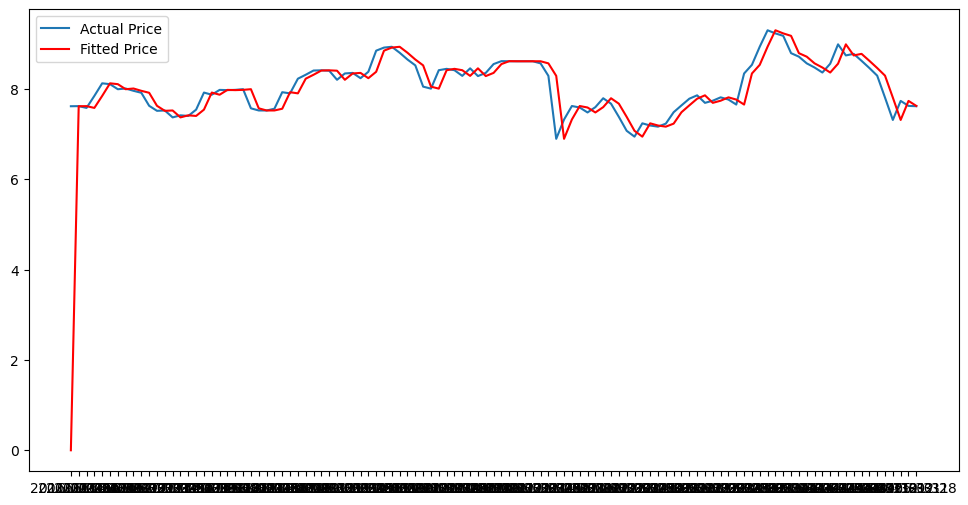

In [110]:
plt.figure(figsize=(12,6))
plt.plot(df['Price'],label='Actual Price')
plt.plot(arima_model.fittedvalues,label='Fitted Price',color='red')
plt.legend()
plt.show()

In [111]:
df['Arima_Predictions']=arima_model.fittedvalues

In [117]:
df

,Price,Predictions,Arima_Predictions
Date,,,
2016-03-31,7.619274,7.616748,7.616748
2016-04-30,7.579727,7.619274,7.619274
2016-05-31,7.845552,7.579727,7.579727
2016-06-30,8.124091,7.845552,7.845552
2016-07-31,8.105396,8.124091,8.124091
...,...,...,...
2024-10-31,7.808368,8.139228,8.294050
2024-11-30,7.313220,7.704584,7.808368
2024-12-31,7.734850,7.161391,7.313220


In [116]:
df=df.drop(df.index[0])

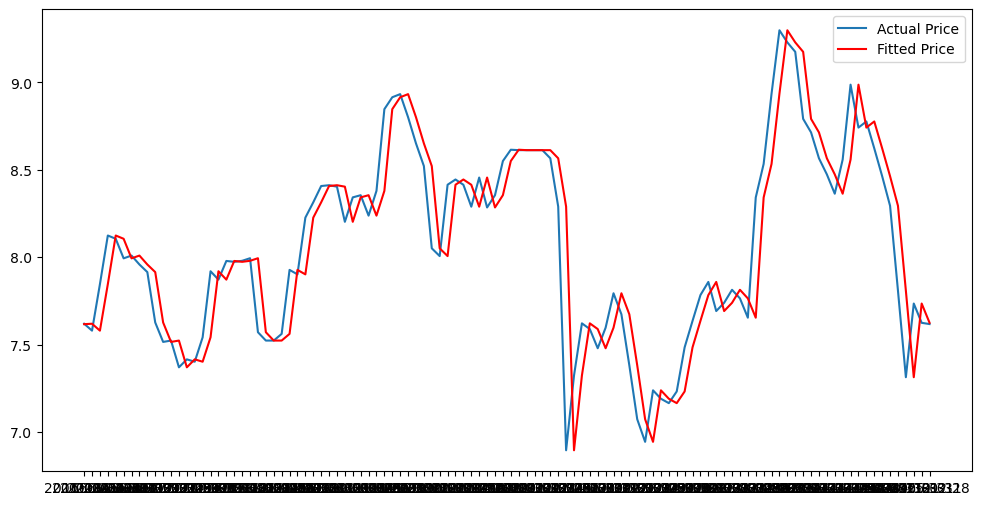

In [118]:
plt.figure(figsize=(12,6))
plt.plot(df['Price'],label='Actual Price')
plt.plot(df['Arima_Predictions'],label='Fitted Price',color='red')
plt.legend()
plt.show()

In [114]:
df.dropna(inplace=True)

In [ ]:
#rmse and 

In [119]:
r2_score(df['Price'],df['Arima_Predictions'])

0.7864792964925662

In [120]:
mae = mean_absolute_error(df['Price'], df['Arima_Predictions'])
rmse = np.sqrt(mean_squared_error(df['Price'], df['Arima_Predictions']))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

MAE: 0.16
RMSE: 0.25
